In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('employee_retention_data.csv')


df.head()


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [2]:
#Create a column that has value 0 or 1 if they stayed or not 
#This will be the y that we will predict

df['left']= np.where(df['quit_date'].isnull(), 0, 1)

In [ ]:
#Lets look at the date range

In [3]:
df['quit_date']=pd.to_datetime(df['quit_date'])

In [4]:
df['join_date']=pd.to_datetime(df['join_date'])

In [5]:
df['quit_date'].max()

Timestamp('2015-12-09 00:00:00')

In [6]:
df['quit_date'].min()

Timestamp('2011-10-13 00:00:00')

In [7]:
df['join_date'].max()

Timestamp('2015-12-10 00:00:00')

In [9]:
max_day=df['join_date'].max()+pd.DateOffset(days=1)

In [10]:
max_day

Timestamp('2015-12-11 00:00:00')

In [11]:
#set time at company from max date for those who continue to work there
df['time_at_company']=df['quit_date']
df['time_at_company'].fillna(max_day,inplace=True)
df['time_at_company']-=df['join_date']

In [12]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,left,time_at_company
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,585 days
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340 days
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0,424 days
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389 days
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040 days


In [13]:
df['time_at_company']=pd.to_timedelta(df['time_at_company'])
df['time_at_company']=df['time_at_company'].dt.days


In [14]:
#salary and seniority are related and senior people who aren't paid much more likely to leave
df['pay_per_seniority']=df['salary']/df['seniority']

In [15]:
#set up a scaled salary by department - not to compare salary of DS with CS, standardize

df['salary_by_dept']=df.groupby(['dept'])['salary'].transform(lambda x: (x - x.mean()) / x.std())

In [16]:
#maybe look at current seniority- combine time at company with time before
df['current_seniority']=df['seniority']+(df['time_at_company']/365.0)

In [17]:
#try salary per combined seniority
df['pay_by_csenior']=df['salary']/df['current_seniority']

In [18]:
#try looking at standardized salary taking into account department and seniority

df['csenior_salary_by_dept']=df.groupby(['dept'])['pay_by_csenior'].transform(lambda x: (x - x.mean()) / x.std())

In [19]:
#look at correlations? is this reasonable for logistic regression??
dfcorr = df.corr(method='spearman')['left']
dfcorr = pd.DataFrame(dfcorr)
dfcorr.columns = ["Correlation"]
dfcorr2 = dfcorr.sort_values(by=['Correlation'], ascending=False)
print(dfcorr2)

                        Correlation
left                       1.000000
time_at_company            0.172171
current_seniority          0.015000
company_id                 0.012738
employee_id                0.001665
seniority                  0.001016
salary_by_dept            -0.003803
salary                    -0.014690
pay_per_seniority         -0.026863
csenior_salary_by_dept    -0.027666
pay_by_csenior            -0.043400


In [ ]:
#oh no nothing is correlated...

In [21]:
#lets look at distributions of those who stayed vs who left
df1=df.loc[df['left'] == 1]
df0=df.loc[df['left'] == 0]

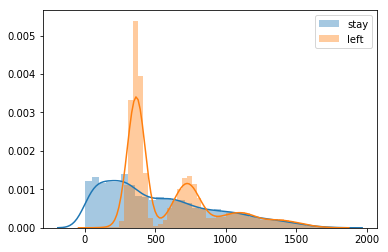

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot((df0[['time_at_company']]), label='stay')
sns.distplot((df1[['time_at_company']]), label='left')
plt.legend()

In [ ]:
#observation- those who left tend to have 2 narrow distributions in their stay at the company


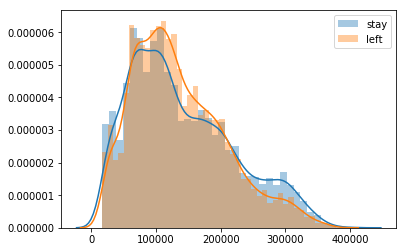

In [23]:
sns.distplot(df0[['salary']], label="stay")
sns.distplot(df1[['salary']], label="left")
plt.legend()

In [ ]:
#observation- 
#P(200,000) > for those who left
#P(300,000) < if left the company

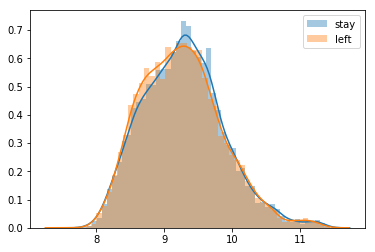

In [25]:
sns.distplot(np.log(df0[['pay_per_seniority']]), label='stay')
sns.distplot(np.log(df1[['pay_per_seniority']]), label='left')
plt.legend()

In [ ]:
#pay per seniority seems similar

In [26]:
df1.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,left,time_at_company,pay_per_seniority,salary_by_dept,current_seniority,pay_by_csenior,csenior_salary_by_dept
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,585,3178.571429,0.213889,29.602740,3006.478482,-1.221037
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340,9150.000000,0.904985,20.931507,8742.801047,-0.338277
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389,5750.000000,1.037199,21.065753,5459.097412,-0.240867
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040,12000.000000,0.878623,25.849315,10677.265501,-0.723105
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,1,578,11785.714286,-0.532481,15.583562,10588.080169,-0.737496


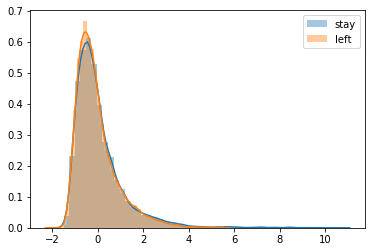

In [28]:
sns.distplot((df0[['csenior_salary_by_dept']]), label='stay')
sns.distplot((df1[['csenior_salary_by_dept']]), label='left')
plt.legend()

In [ ]:
#csenior seems very similar

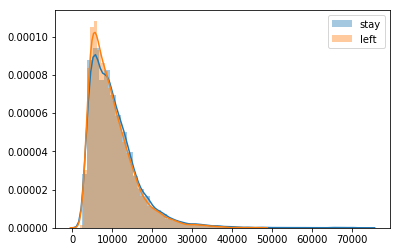

In [29]:
sns.distplot((df0[['pay_by_csenior']]), label='stay')
sns.distplot((df1[['pay_by_csenior']]), label='left')
plt.legend()

In [ ]:
#variables are correlated, haven't been able to engineer one single feature
#that stands out

In [ ]:
#next i would do logistic regression but I've run out of time to do it now
